## Logistic Regression Hands-On

In this notebook, we go over Logistic Regression to predict the __isPositive__ field of our Amazon Product Review dataset. 

1. <a href="#1">Read the dataset</a>
2. <a href="#2">Exploratory Data Analysis</a>
3. <a href="#3">Select features to build the model</a>
4. <a href="#4">Data processing using Bag of Words</a>
5. <a href="#5">Train a classifier</a>

*Find more details on the classical Linear Regression models [here](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.linear_model).*

__Amazon Product Review Dataset__:

In this exercise, we are working with a product review dataset from Amazon. The raw data is available [here](https://nijianmo.github.io/amazon/index.html). You can find this dataset under `DATA/product-reviews`: Amazon_Reviews_Regression.csv and Amazon_Reviews_Classification.csv.

__Dataset schema:__ 
* __reviewText__ - Text of the review
* __summary__ - Summary of the review
* __verified__ - Whether the purchase was verified (True or False)
* __time__ - UNIX timestamp for the review
* __rating__ - Rating of the review.
* __log_votes__ - Logarithm-adjusted votes log(1+votes). 
* __isPositive__ - Whether the review is positive (1 or 0). This is the field to predict.

## 1. Read the dataset
(<a href="#0">Go to top</a>)

We will use the Pandas library to read our dataset.

In [2]:
# Copyright Amazon.com, Inc. or its affiliates. All Rights Reserved
# SPDX-License-Identifier: MIT-0

import matplotlib.pyplot as plt
import pandas as pd

df = pd.read_csv('../../DATA/product-reviews/Amazon_Reviews_Classification.csv')

print('The shape of the dataset is:', df.shape)

The shape of the dataset is: (70000, 6)


Let's look at the first five rows in the dataset. As you can see the __isPositive__ field only contains two categories. That's why we will build a classification model.

In [3]:
df.head()

reviewText  \
0  PURCHASED FOR YOUNGSTER WHO\nINHERITED MY "TOO...   
1                              unable to open or use   
2   Waste of money!!! It wouldn't load to my system.   
3  I attempted to install this OS on two differen...   
4  I've spent 14 fruitless hours over the past tw...   

                                             summary  verified        time  \
0                                IDEAL FOR BEGINNER!      True  1361836800   
1                                          Two Stars      True  1452643200   
2                                       Dont buy it!      True  1433289600   
3  I attempted to install this OS on two differen...      True  1518912000   
4                                   Do NOT Download.      True  1441929600   

   log_votes  isPositive  
0   0.000000         1.0  
1   0.000000         0.0  
2   0.000000         0.0  
3   0.000000         0.0  
4   1.098612         0.0

## 2. Exploratory Data Analysis
(<a href="#0">Go to top</a>)

Let's look at the distribtion of the only numerical feature in the dataset (`log_votes`).

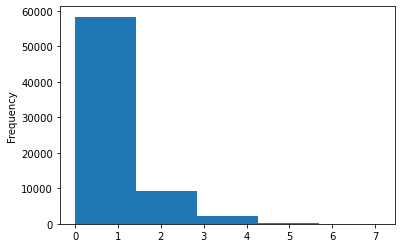

In [4]:
# Please complete code here.
%matplotlib inline
import matplotlib.pyplot as plt
df['log_votes'].plot.hist(bins=5)
plt.show()

Let's look at the distribution of the categorical column in the dataset (`verified`).

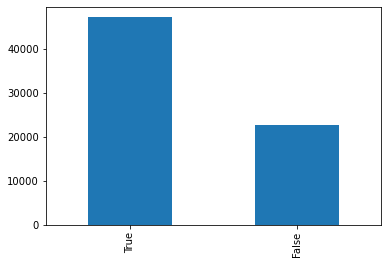

In [5]:
# Please complete code here.
df['verified'].value_counts().plot.bar()
plt.show()

#### Target distribution

Please check the target distribution and assess whether it is skewed towards one category or another.

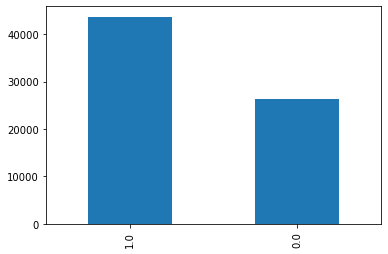

In [6]:
# Please complete code here.
df['isPositive'].value_counts().plot.bar()
plt.show()

#### Missing values
Identify in the following section whether there are any missing values (how many missing values are there per column?).

In [7]:
# Please complete code here.
print(df.isna().sum())

reviewText    11
summary       14
verified       0
time           0
log_votes      0
isPositive     0
dtype: int64


### Imputation
Let's fill-in the missing values for __reviewText__ below. We will just use the placeholder "Missing" here. We will focus on the __reviewText__ column and drop the __summary__ column later, so there is no need to fill the missing values for __summary__.

In [8]:
df["reviewText"].fillna("Missing", inplace=True)

Depending on how many missing values there are in the dataset it might also be a good idea to drop the rows that contain missing values instead of imputing.

Alternatively, there are also 'smart' imputers such as AWS Datawig [here](https://github.com/awslabs/datawig). Datawig uses Machine Learning to find good substitutes for missing values.

It is also possible to impute with the most frequent or average value. To do this, sklearn has an Imputer class [here](https://scikit-learn.org/stable/modules/generated/sklearn.impute.SimpleImputer.html).

## 3. Selecting features to build the model
(<a href="#0">Go to top</a>)

In this particular dataset, there are 2 text based columns which we want to prepare to use and 1 categorical and 1 numerical column each. Try to extract the weekday from the __time__ column using the below code snippet to create a new categorical column called __weekday__.


```
import datetime
df['weekday'] = df['time'].apply(lambda x: datetime.datetime.fromtimestamp(x).weekday())
df['weekday'] = df['weekday'].astype(str)
```

In [9]:
import datetime
df['weekday'] = df['time'].apply(lambda x: datetime.datetime.fromtimestamp(x).weekday())
df['weekday'] = df['weekday'].astype(str)

In [10]:
df['weekday'] = df['weekday'].astype(str)

Also, make sure to drop the __summary__ column.

In [11]:
df.drop('summary', axis = 1, inplace = True)

#### Cleaning text features 

Text cleaning can be performed here, before train/test split, with less code. The cleaning should happen after stop words have been removed as there will be fewer words to process.

In [12]:
# Install the library and functions
import nltk

nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /home/ec2-user/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/ec2-user/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

We will create the stop word removal and text cleaning processes below. NLTK library provides a list of common stop words. We will use the list, but remove some of the words from that list (because those words are actually useful to understand the sentiment in the sentence).

In [13]:
import nltk, re
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from nltk.tokenize import word_tokenize

# Let's get a list of stop words from the NLTK library
stop = stopwords.words('english')

# These words are important for our problem. We don't want to remove them.
excluding = ['against', 'not', 'don', "don't",'ain', 'aren', "aren't", 'couldn', "couldn't",
             'didn', "didn't", 'doesn', "doesn't", 'hadn', "hadn't", 'hasn', "hasn't", 
             'haven', "haven't", 'isn', "isn't", 'mightn', "mightn't", 'mustn', "mustn't",
             'needn', "needn't",'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', 
             "weren't", 'won', "won't", 'wouldn', "wouldn't"]

# New stop word list
stop_words = [word for word in stop if word not in excluding]

snow = SnowballStemmer('english')

def process_text(texts): 
    final_text_list=[]
    for sent in texts:
        filtered_sentence=[]
        
        sent = sent.lower() # Lowercase 
        sent = sent.strip() # Remove leading/trailing whitespace
        sent = re.sub('\s+', ' ', sent) # Remove extra space and tabs
        sent = re.compile('<.*?>').sub('', sent) # Remove HTML tags/markups:
        
        for w in word_tokenize(sent):
            # We are applying some custom filtering here, feel free to try different things
            # Check if it is not numeric and its length>2 and not in stop words
            if(not w.isnumeric()) and (len(w)>2) and (w not in stop_words):  
                # Stem and add to filtered list
                filtered_sentence.append(snow.stem(w))
        final_string = " ".join(filtered_sentence) #final string of cleaned words
 
        final_text_list.append(final_string)
    
    return final_text_list

In [14]:
df["reviewText"] = process_text(df["reviewText"].tolist()) 

In [15]:
df['verified'] = df['verified'].astype(str)

## 4. Data processing using Bag of Words (BoW)
(<a href="#0">Go to top</a>)

Create a simple pipeline using column transformer. Make sure to create pre-processing pipelines for every data type (text, numerical, categorical).

In [16]:
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer


### COLUMN_TRANSFORMER ###
##########################

# Preprocess the numerical features
numerical_processor = Pipeline([
    ('num_scaler', MinMaxScaler()) 
                                ])
                  
# Preprocess the categorical features
categorical_processor = Pipeline([
    ('cat_encoder', OneHotEncoder(handle_unknown='ignore')) 
                                ])
# Preprocess 1st text feature
text_processor = Pipeline([
    ('text_vect', CountVectorizer(binary=False, max_features=250))
                                ])


# Combine all data preprocessors from above
data_preprocessor = ColumnTransformer([
    ('numerical_pre', numerical_processor, ['log_votes']),
    ('categorical_pre', categorical_processor, ['verified', 'weekday']),
    ('text_pre', text_processor, ['reviewText'][0]),
                                    ]) 

## 5. Train a classifier
(<a href="#0">Go to top</a>)

### LogisticRegression
Let's fit __LogisticRegression__ from Sklearn library. Find more details on __LogisticRegression__ [here](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html).

In [17]:
from sklearn import set_config
set_config(display='diagram')

X_train, y_train = df[["reviewText", "log_votes", "verified", "weekday"]], df["isPositive"].tolist()


from sklearn.linear_model import LogisticRegression

### PIPELINE ###
################

lr_pipeline = Pipeline([
    ('data_preprocessing', data_preprocessor),
    ('lrClassifier', LogisticRegression('none'))
                    ])

Train the model using the `.fit()` method. Make sure to match the model name from above.


In [18]:
# Please complete code here.
lr_pipeline.fit(X_train, y_train)

Pipeline(steps=[('data_preprocessing',
                 ColumnTransformer(transformers=[('numerical_pre',
                                                  Pipeline(steps=[('num_scaler',
                                                                   MinMaxScaler())]),
                                                  ['log_votes']),
                                                 ('categorical_pre',
                                                  Pipeline(steps=[('cat_encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['verified', 'weekday']),
                                                 ('text_pre',
                                                  Pipeline(steps=[('text_vect',
                                                                   CountVectorizer(max_features=250))]),
                                                  'reviewText')])),
                ('lrClassifier', LogisticRegression(penalty='none'))])

In [19]:
print("LogisticRegression model weights: \n", len(lr_pipeline[-1].coef_[0]))

LogisticRegression model weights: 
 260


### Regularization

Regularization is a technique used for reducing the number of features the model uses by adding an additional penalty term in the error function. It can help make the model simpler and generalize better to unseen data.

There exist different regularization techniques and we will explore 2 of those in the sections below:

#### Ridge (L2 regularization)
Let's now fit __LogisticRegression__ from Sklearn library with the so-called Ridge penalty term, and check how many model weights remain after the regularization is applied.

Find more details on __Ridge__ [here](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html).

To improve the performance of a LinearRegression model, __Ridge__ is tuning model complexity by adding a $L_2$ penalty score for complexity to the model cost function:

$$\text{C}_{\text{regularized}}(\textbf{w}) = \text{C}(\textbf{w}) +  {alpha}∗||\textbf{w}||_2^2$$

where $\textbf{w}$ is the model weights vector, and $||\textbf{w}||_2^2 = \sum \textbf{w}_i^2$.

The strength of the regularization is controlled by the regularizer parameter, alpha: smaller value of $alpha$, weaker regularization; larger value of $alpha$, stronger regularization. 


In [20]:
ridge_pipeline = Pipeline([
    ('data_preprocessing', data_preprocessor),
    ('lrClassifier', LogisticRegression(penalty='l2'))
                    ])

# Train the model
ridge_pipeline.fit(X_train, y_train)

Pipeline(steps=[('data_preprocessing',
                 ColumnTransformer(transformers=[('numerical_pre',
                                                  Pipeline(steps=[('num_scaler',
                                                                   MinMaxScaler())]),
                                                  ['log_votes']),
                                                 ('categorical_pre',
                                                  Pipeline(steps=[('cat_encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['verified', 'weekday']),
                                                 ('text_pre',
                                                  Pipeline(steps=[('text_vect',
                                                                   CountVectorizer(max_features=250))]),
                                                  'reviewText')])),
                ('lrClassifier', LogisticRegression())])

In [21]:
print("LogisticRegression model weights with Ridge and threshold at |0.5|: \n", len(ridge_pipeline[-1].coef_[0][abs(ridge_pipeline[-1].coef_[0]) > 0.5]))

LogisticRegression model weights with Ridge and threshold at |0.5|: 
 21


#### LASSO ( L1 regularization)
Let's also fit __LogisticRegression__ with Lasso penalty from Sklearn.

Find more details on __Lasso__ [here](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html).

__Lasso__ is tuning model complexity by adding a $L_1$ penalty score for complexity to the model cost function:

$$\text{C}_{\text{regularized}}(\textbf{w}) = \text{C}(\textbf{w}) +  alpha∗||\textbf{w}||_1$$

where $\textbf{w}$ is the model weights vector, and $||\textbf{w}||_1 = \sum |\textbf{w}_i|$. 

Again, the strength of the regularization is controlled by the regularizer parameter, $alpha$. Due to the geometry of $L_1$ norm, with __Lasso__, some of the weights will shrink all the way to 0, leading to sparsity - some of the features are not contributing to the model afterall!

In [22]:
lasso_pipeline = Pipeline([
    ('data_preprocessing', data_preprocessor),
    ('lrClassifier', LogisticRegression(penalty='l1', solver = 'liblinear'))
                    ])

# Train the model
lasso_pipeline.fit(X_train, y_train)

Pipeline(steps=[('data_preprocessing',
                 ColumnTransformer(transformers=[('numerical_pre',
                                                  Pipeline(steps=[('num_scaler',
                                                                   MinMaxScaler())]),
                                                  ['log_votes']),
                                                 ('categorical_pre',
                                                  Pipeline(steps=[('cat_encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['verified', 'weekday']),
                                                 ('text_pre',
                                                  Pipeline(steps=[('text_vect',
                                                                   CountVectorizer(max_features=250))]),
                                                  'reviewText')])),
                ('lrClassifier',
                 LogisticRegression(penalty='l1', solver='liblinear'))])

In [23]:
print("LogisticRegression model weights with Lasso: \n", len(lasso_pipeline[-1].coef_[0][abs(lasso_pipeline[-1].coef_[0]) != 0]))

LogisticRegression model weights with Lasso: 
 260
